# Extracting Keypoints (Interest Points)

In [23]:
import math
import os
import sys

sys.path.insert(0, os.path.abspath('/data/autocnet'))

import autocnet
from autocnet import CandidateGraph

# The GPU based extraction library that contains SIFT extraction and matching
import cudasift as cs

# A method to resize the images on the fly.
from scipy.misc import imresize

%pylab inline
figsize(16,4)

Populating the interactive namespace from numpy and matplotlib


## Candidate Graph
As before, create the candidate graph object that stores the adjacency between images.

In [2]:
a = 'AS15-P-0111_CENTER_LRG_CROPPED.png'
b = 'AS15-P-0112_CENTER_LRG_CROPPED.png'

adj = {a:[b],
       b:[a]}

cg = CandidateGraph.from_adjacency(adj)

## Enable GPU use

The library can utilize either the CPU or the GPU for a number of computationally expensive functions.  One example if [keypoint or correspondence identification](https://en.wikipedia.org/wiki/Correspondence_problem).  The process of finding correspondences requires 3 steps:

- The identification of [interest points](https://en.wikipedia.org/wiki/Interest_point_detection).
- The extraction of said interest points
- Matching of interest points between images to identify correspondences.

We support this processing flow using:

- (OpenCV functionality)[http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_table_of_contents_feature2d/py_table_of_contents_feature2d.html]
- (VLFeat)[http://www.vlfeat.org]
- (CUDA SIFT)[https://github.com/USGS-Astrogeology/CudaSift]

CUDA SIFT is exceptionally fast as it extracts (and matches) keypoints in parallel on 1000s of GPU cores.  For all but the smallest images, GPU use is encouraged.

![gpu](https://upload.wikimedia.org/wikipedia/commons/b/bd/CPU_and_GPU.png)

In house, my work station is available with 2 M5000 GPUs containing approximately 2500 GPU cores and 8GB of RAM each.  The GPU processing node has 4 K80 GPUs with ~5000 GPU cores and 12GB of RAM each.

In [5]:
autocnet.cuda(enable=True, gpu=0)  # Explicitly select a GPU since the system has 2 and GPU1 is running monitors.

A GPU with 8GB of memory can run the SIFT algorithm for approximately $12500^{2}$ pixels.  The CudaSift code is written to support 32-bit floating point numbers (a major improvement over OpenCV for our use case).  This is also a limiting factor as the 8-bit Apollo Pan `.png` files are taking up significantly more space than they really need.



In [7]:
# check the total size of the input image.
cg.node[0].geodata.raster_size

(59720, 11510)

## Aside: AutoCNet as a library

We have developed the AutoCNet library and not an end-to-end application intentionally.  The Apollo Pan data is a prime example of why this decision was made.  The images are unique and the order and pre-processing required for successful matching require chaining the AutoCNet functionality in a unique way.  The "application" can be taylored to the data as opposed to expanding the application to support all possible processing paths.

![autolib](https://github.com/USGS-Astrogeology/autocnet/blob/dev/docs/_static/images/autocnet_modules.png?raw=true)

#### Modules:

- `graph`: This module manages the CandidateGraph, Node, and Edge constructs.  All of the syntax sugar is embedded in these objects.
- `matcher`: The meat-and-potatoes module with our CPU/GPU feature matchers, subpixel matchers, outlier detection methods, and spatial suppression functions.
- `camera`: Lightweight pinhole camera capabilities for working with epipolar lines, estimating the relationship between an ideal pinhole and non-ideal pinhole using image correspondences, and triangulation.
- `transformation`: Decomposition and transformation (fundamental and homography) matrices.
- `control`: ISIS3 style control class (not broadly used).
- `cg`: Computational Geometry module with convex hull and Voronoi diagram functionality.
- `vis`: A tiny visualization module - AutoCNet is not a collection of data views, but a library.  This module is designed for quick development peaks at the state of things.
- `plio/io`: The `plio` library is leveraged heavily to support I/O.  We also have a lightweight io module within AutoCNet for saving/loading this project.
- `utils`: This module contains an assortment of utility functions for linear algebra operations (aggregating numpy functions), nearest neighbor searches, recursive dict traversal, etc.

## Images that are too large

A few options exist for images that are too large for the SIFT algorithm.  If geospatial information existed, it would be possible to contrain the extraction to just the overlap between two (or more) images.  We could then cross our fingers and hope that the overlap area was small enough to fit onto a GPU.  Alternatively, it is possible to downsample the image and work with the reduced resolution initially.  Due to these challenges, the [syntax sugar](https://en.wikipedia.org/wiki/Syntactic_sugar) that exists on the `CandidateGraph`, `Node` and `Edge` objects are largely unusable.

What follows is the result of experimentation with the images.

**Step I**: Read the input images from a node's geodata object, downsample the image so it will fit in memory and extract keypoints.

In [19]:
# Read the image into memory from disk
# Image 1
arr0 = cg.node[0].geodata.read_array()

# Check the size of the image 
total_size = arr0.shape[0] * arr0.shape[1]
downsample_amount = math.ceil(total_size / 12500**2)

# Compute the new shape of the output and downsample using Lanczos interpolation
shape = (int(arr0.shape[0] / downsample_amount), int(arr0.shape[1] / downsample_amount))
arr0 = imresize(arr0, shape, interp='lanczos')

# Compute the approximate number of points to extract - we are looking for good coverage without being super dense.  This took a bit of trial and error
npts = max(arr0.shape) / 3.5

# Create the SiftData object to store the results
sd0 = cs.PySiftData(npts)

# Extract the keypoints.
cs.ExtractKeypoints(arr0, sd0, thresh=1)
kp0, des0 = sd0.to_data_frame()
kp0 = kp0[['x', 'y', 'scale', 'sharpness', 'edgeness', 'orientation', 'score', 'ambiguity']]
kp0['score'] = 0.0
kp0['ambiguity'] = 0.0

# Check the total number returned
print(len(kp0))

3412


## Parameterization & Result Visualization

The `cs.ExtractKeypoints` function takes the input array (image) and sift data object as mandatory input parameters.  We also pass `thresh=1` in.  This parameter controls the threshold for pruning Difference of Gaussian (DoG) features.  In short - if not enough features are being identified, try reducing the `thresh` parameter.


In the above, we got 3412 (or there abouts on a rerun) points.  What is important is the spatial distirbution of these.  Below, we visualize these to check the distribution.

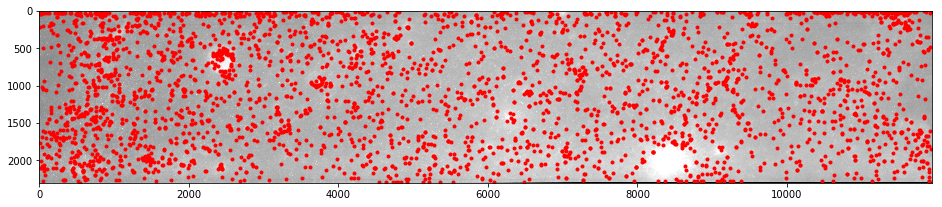

In [26]:
imshow(arr0, cmap='gray')
plot(kp0['x'], kp0['y'], 'ro', markersize=3)

## Repeat for the other array

The spatial distribution looks good - time to repeat for the next image!

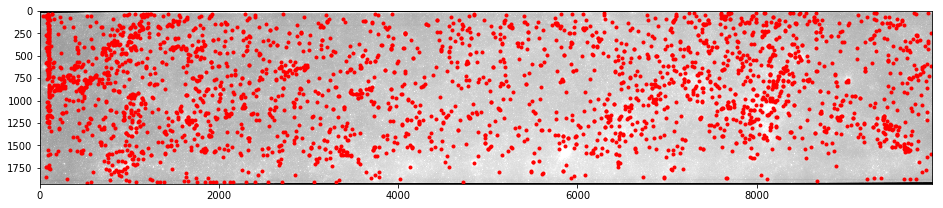

In [27]:
# Image 2
arr1 = cg.node[1].geodata.read_array()
shape = (int(arr1.shape[0] / 6), int(arr1.shape[1] / 6)) # 5 because the max number of pixels is 12500^2
arr1 = imresize(arr1, shape, interp='lanczos')
npts = max(arr1.shape) / 3.5
sd1 = cs.PySiftData(npts)

cs.ExtractKeypoints(arr1, sd1, thresh=1)
kp1, des1 = sd1.to_data_frame()
kp1 = kp1[['x', 'y', 'scale', 'sharpness', 'edgeness', 'orientation', 'score', 'ambiguity']]
kp1['score'] = 0.0
kp1['ambiguity'] = 0.0

imshow(arr1, cmap='gray')
plot(kp1['x'], kp1['y'], 'ro', markersize=3)

Interesting linear feature on the left, but overall looks okay.  It might be nice to get a few more correspondences, but lets try this for now.